In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.base import clone
import umap
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif, SelectKBest, chi2
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils import resample
from scipy.sparse import issparse, hstack
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the dataset
df = pd.read_csv('training.1600000.processed.noemoticon.csv',
                 encoding='ISO-8859-1',
                 names=['target', 'id', 'date', 'flag', 'user', 'text'])

In [4]:
# Display basic information
print("Dataset Shape:", df.shape)

Dataset Shape: (1600000, 6)


In [5]:
print("First few rows:")
display(df.head())

First few rows:


,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
# Data Preprocessing
# Convert target to binary (0 for negative, 1 for positive)
df['target'] = df['target'].map({0: 0, 4: 1})

# Text preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

df['processed_text'] = df['text'].apply(preprocess_text)


In [8]:
df['processed_text']

0          switchfoot httptwitpiccomyzl  awww thats a bum...
1          is upset that he cant update his facebook by t...
2          kenichan i dived many times for the ball manag...
3            my whole body feels itchy and like its on fire 
4          nationwideclass no its not behaving at all im ...
                                 ...                        
1599995    just woke up having no school is the best feel...
1599996    thewdbcom  very cool to hear old walt intervie...
1599997    are you ready for your mojo makeover ask me fo...
1599998    happy th birthday to my boo of alll time tupac...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: processed_text, Length: 1600000, dtype: object

In [9]:
# Add to TextPreprocessor class
def advanced_preprocess(self, text):
    # Handle contractions
    text = self.expand_contractions(text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove emails
    text = re.sub(r'\S+@\S+', '', text)
    # Remove numbers with context
    text = re.sub(r'\w*\d\w*', '', text)
    return text

In [10]:
def add_custom_features(X_tfidf, texts):
    # Text length
    text_lengths = np.array([len(text.split()) for text in texts])
    # Unique words ratio
    unique_words_ratio = np.array([len(set(text.split()))/len(text.split())
                                 for text in texts])
    # Combine with TF-IDF features
    return hstack([X_tfidf, text_lengths.reshape(-1, 1),
                  unique_words_ratio.reshape(-1, 1)])

Word Cloud for Positive Sentiment:


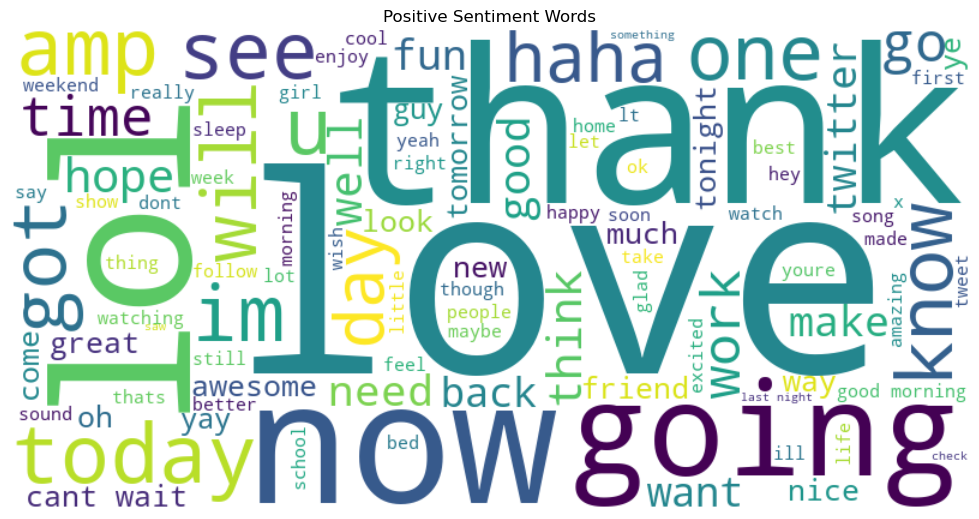


Word Cloud for Negative Sentiment:


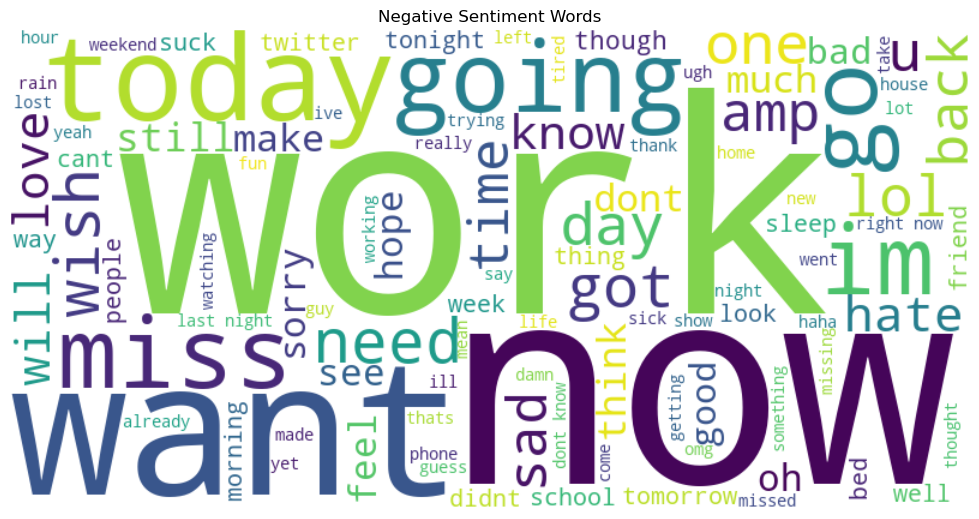

In [11]:
# Create separate word clouds for positive and negative sentiments
def create_sentiment_wordcloud(df, sentiment, title):
    # Combine all processed text for the given sentiment
    text = ' '.join(df[df['target'] == sentiment]['processed_text'])

    # Create and generate word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='White',
        max_words=100,
        stopwords=STOPWORDS,
        min_font_size=10
    ).generate(text)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout(pad=0)
    plt.show()

# Generate word clouds for both sentiments
print("Word Cloud for Positive Sentiment:")
create_sentiment_wordcloud(df, 1, 'Positive Sentiment Words')

print("\nWord Cloud for Negative Sentiment:")
create_sentiment_wordcloud(df, 0, 'Negative Sentiment Words')

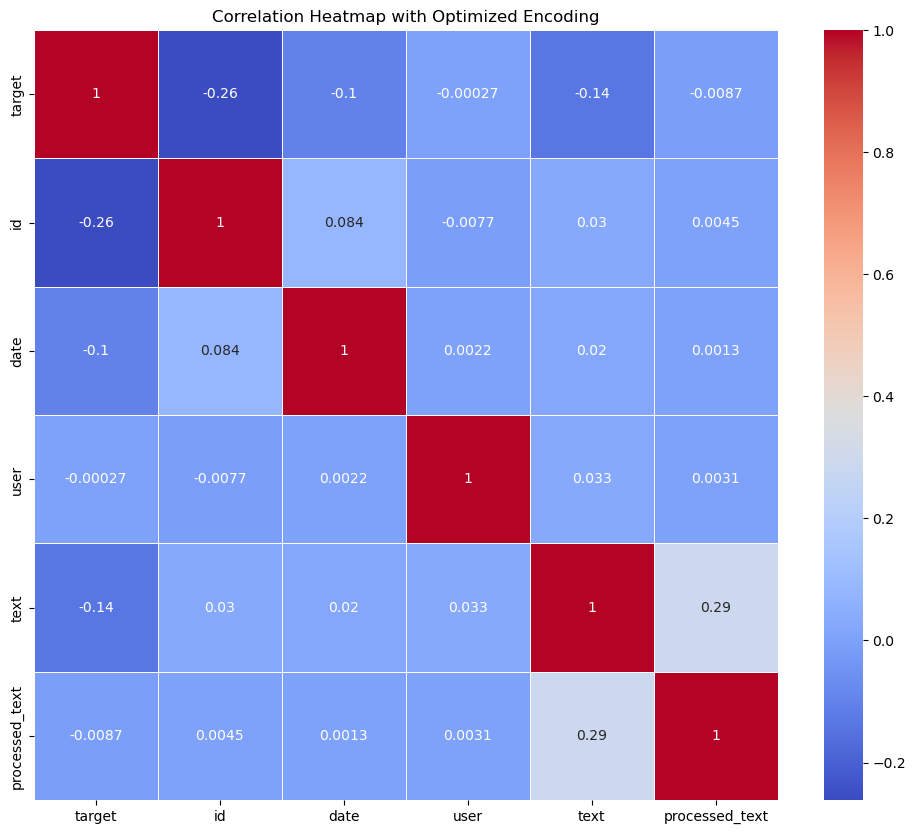

In [12]:
def plot_correlation_heatmap_reduced(df):
    """
    Plots a correlation heatmap for all features, limiting high-cardinality categorical features.
    """
    # Fill missing values to avoid errors
    df_clean = df.fillna(0)

    # Identify high-cardinality categorical features (arbitrarily set to >50 unique values)
    categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns
    high_cardinality_cols = [col for col in categorical_cols if df_clean[col].nunique() > 50]

    # Encode high-cardinality categorical features with OrdinalEncoder
    encoder = OrdinalEncoder()
    for col in high_cardinality_cols:
        df_clean[col] = encoder.fit_transform(df_clean[[col]])

    # One-hot encode remaining categorical features
    df_encoded = pd.get_dummies(df_clean, columns=[col for col in categorical_cols if col not in high_cardinality_cols], drop_first=True)

    # Compute the correlation matrix
    correlation_matrix = df_encoded.corr()

    # Plot the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
    plt.title('Correlation Heatmap with Optimized Encoding')
    plt.show()

# Example call
plot_correlation_heatmap_reduced(df)


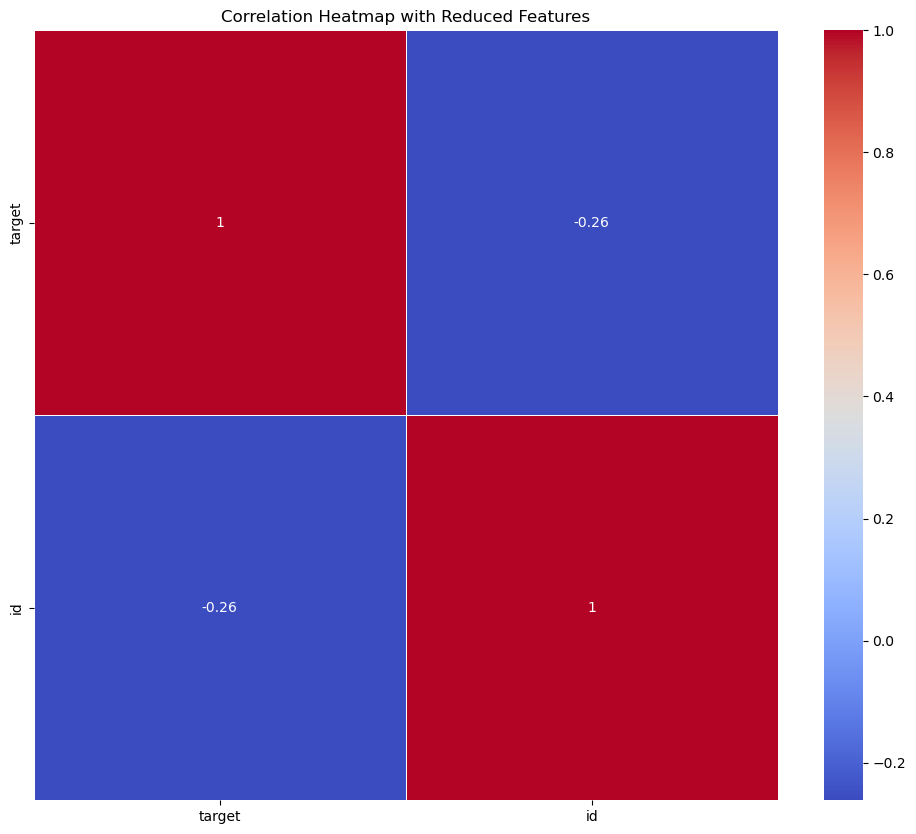

In [13]:
def plot_correlation_heatmap_drop_high_cardinality(df, threshold=50):
    """
    Plots a correlation heatmap after dropping high-cardinality features.
    """
    df_clean = df.fillna(0)

    # Drop high-cardinality categorical features
    for col in df_clean.select_dtypes(include=['object', 'category']).columns:
        if df_clean[col].nunique() > threshold:
            df_clean.drop(columns=[col], inplace=True)

    # One-hot encode remaining categorical features
    df_encoded = pd.get_dummies(df_clean, drop_first=True)

    # Compute the correlation matrix
    correlation_matrix = df_encoded.corr()

    # Plot the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
    plt.title('Correlation Heatmap with Reduced Features')
    plt.show()

# Example call
plot_correlation_heatmap_drop_high_cardinality(df, threshold=50)


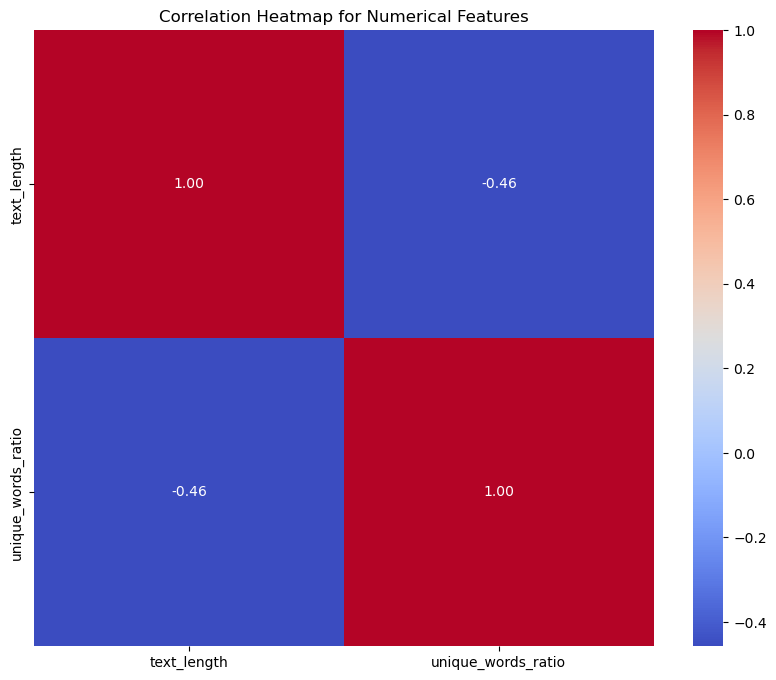

In [14]:
# Correlation Plot for Feature Analysis
def plot_correlation_heatmap(df, feature_columns):
    """
    Plots a correlation heatmap for given feature columns in the dataframe.
    """
    # Compute the correlation matrix
    correlation_matrix = df[feature_columns].corr()

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
    plt.title('Correlation Heatmap for Numerical Features')
    plt.show()

# Call the function with selected numerical features
numerical_features = ['text_length', 'unique_words_ratio']
df['text_length'] = df['processed_text'].apply(lambda x: len(x.split()))
df['unique_words_ratio'] = df['processed_text'].apply(lambda x: len(set(x.split())) / len(x.split()))
plot_correlation_heatmap(df, numerical_features)


In [15]:
# Feature Extraction
# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')



X = tfidf.fit_transform(df['processed_text'])
y = df['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

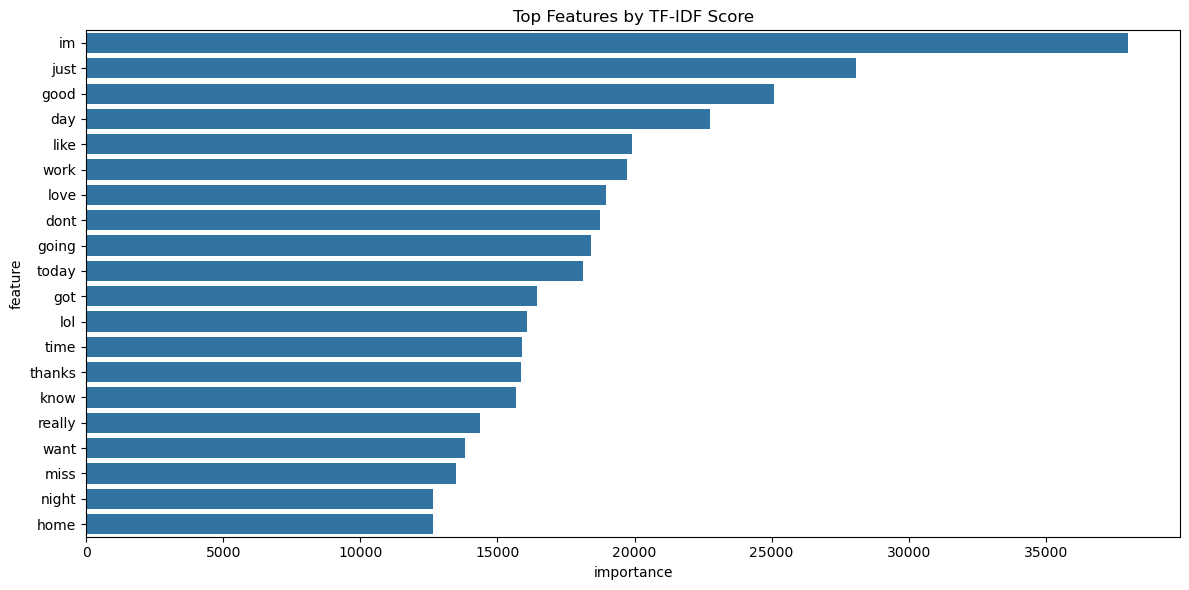

In [16]:
# Visualization 1: Feature Importance
def plot_top_features(tfidf, n=20):
    feature_importance = np.array(X.sum(axis=0)).ravel()
    feature_names = tfidf.get_feature_names_out()

    top_features = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=top_features.head(n), x='importance', y='feature')
    plt.title('Top Features by TF-IDF Score')
    plt.tight_layout()
    plt.show()

plot_top_features(tfidf)

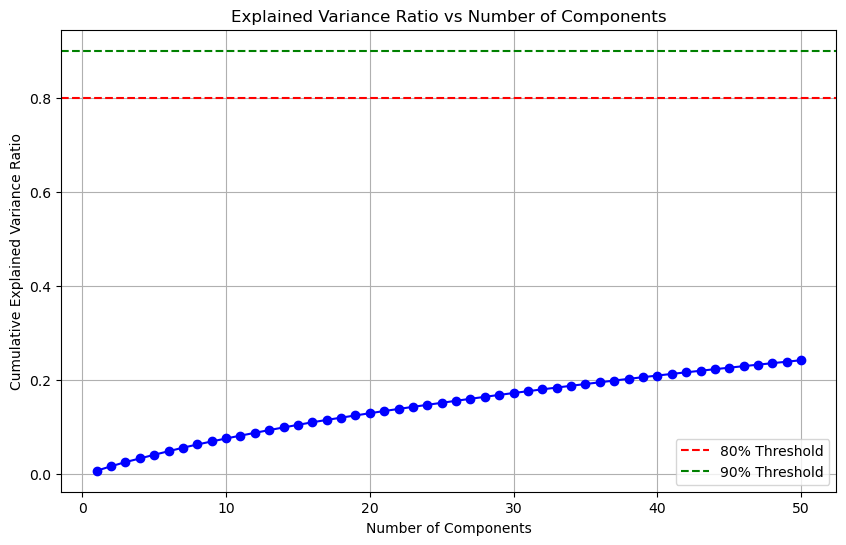


Explained Variance Analysis:
First component explains: 0.68%
First 5 components explain: 4.07%
Components needed for 70% variance: 1
Components needed for 80% variance: 1
Components needed for 90% variance: 1


In [17]:
def analyze_explained_variance(X_sparse, n_components=None):
    """
    Analyze and plot explained variance for sparse matrix
    """
    if n_components is None:
        n_components = min(X_sparse.shape[1] - 1, 100)

    # Perform TruncatedSVD
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    svd.fit(X_sparse)

    # Calculate cumulative explained variance ratio
    cumulative_variance_ratio = np.cumsum(svd.explained_variance_ratio_)

    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance_ratio) + 1),
             cumulative_variance_ratio, 'bo-')
    plt.axhline(y=0.8, color='r', linestyle='--', label='80% Threshold')
    plt.axhline(y=0.9, color='g', linestyle='--', label='90% Threshold')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Explained Variance Ratio vs Number of Components')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print key variance thresholds
    print("\nExplained Variance Analysis:")
    print(f"First component explains: {svd.explained_variance_ratio_[0]:.2%}")
    print(f"First 5 components explain: {np.sum(svd.explained_variance_ratio_[:5]):.2%}")

    # Find number of components needed for different thresholds
    thresholds = [0.7, 0.8, 0.9]
    for threshold in thresholds:
        n_comp = np.argmax(cumulative_variance_ratio >= threshold) + 1
        print(f"Components needed for {threshold:.0%} variance: {n_comp}")

    return svd

# Modify TF-IDF parameters to capture more variance
tfidf = TfidfVectorizer(
    max_features=1000,  # Reduced from 5000
    min_df=5,          # Remove rare terms
    max_df=0.95,       # Remove very common terms
    stop_words='english'
)

# Fit and transform the data
X = tfidf.fit_transform(df['processed_text'])

# Analyze variance
svd_model = analyze_explained_variance(X, n_components=50)

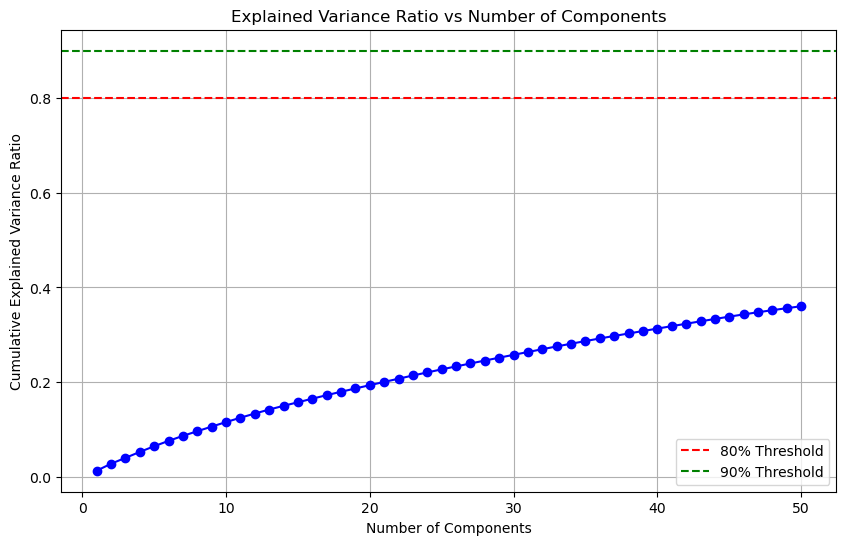


Explained Variance Analysis:
First component explains: 1.27%
First 5 components explain: 6.44%
Components needed for 70% variance: 1
Components needed for 80% variance: 1
Components needed for 90% variance: 1


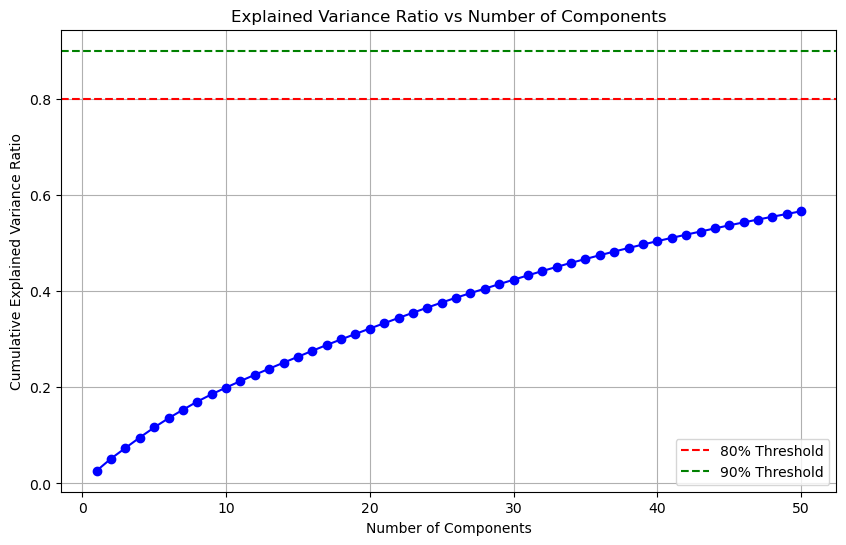


Explained Variance Analysis:
First component explains: 2.65%
First 5 components explain: 11.65%
Components needed for 70% variance: 1
Components needed for 80% variance: 1
Components needed for 90% variance: 1


In [18]:
# Feature selection to remove noise
from sklearn.feature_selection import SelectKBest, chi2

# Select top features based on chi-square test
selector = SelectKBest(chi2, k=500)
X_selected = selector.fit_transform(X, y)

# Analyze variance with selected features
svd_model_improved = analyze_explained_variance(X_selected, n_components=50)

# If still low, try reducing dimensionality further
if np.sum(svd_model_improved.explained_variance_ratio_) < 0.8:
    # Try with even fewer features
    selector = SelectKBest(chi2, k=200)
    X_selected = selector.fit_transform(X, y)
    svd_model_final = analyze_explained_variance(X_selected, n_components=50)

Performing PCA...
Performing TruncatedSVD...
Performing t-SNE...
Performing UMAP...


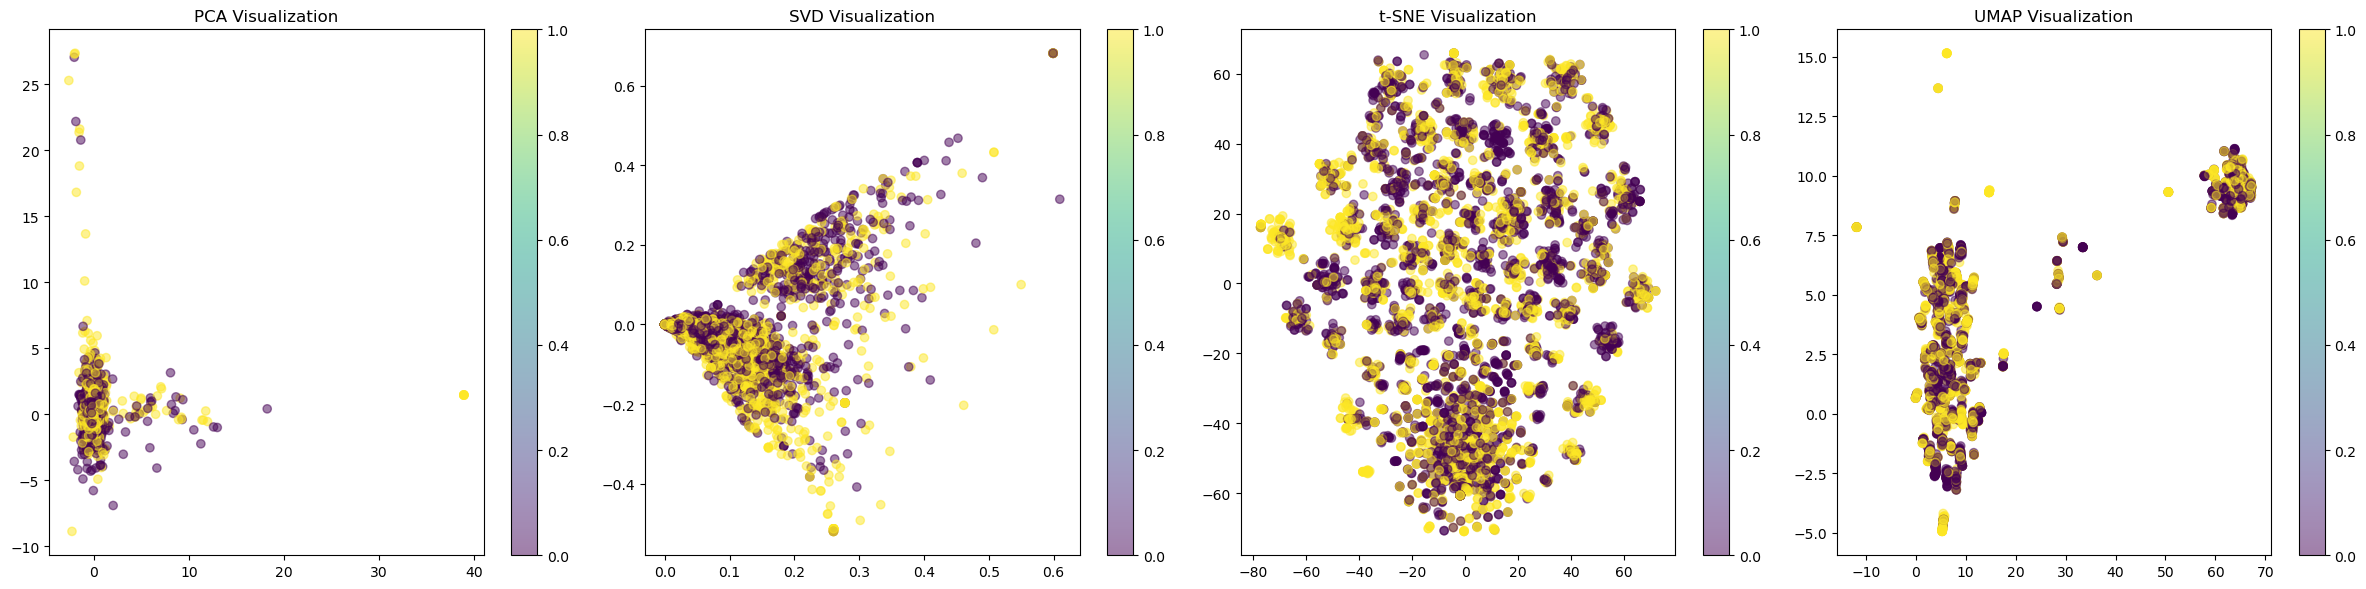

In [19]:
def optimize_dimensionality_reduction(X_sparse, y, sample_size=5000):
    """
    Efficient dimensionality reduction with sampling, including PCA
    """
    # Sample data if it's too large
    if X_sparse.shape[0] > sample_size:
        X_sampled, y_sampled = resample(X_sparse, y,
                                      n_samples=sample_size,
                                      random_state=42)
    else:
        X_sampled, y_sampled = X_sparse, y

    results = {}

    # 1. PCA (on dense data)
    print("Performing PCA...")
    # Convert sparse matrix to dense for PCA
    X_dense = X_sampled.toarray()
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_dense)
    # Apply PCA
    pca = PCA(n_components=2, random_state=42)
    results['PCA'] = pca.fit_transform(X_scaled)

    # 2. TruncatedSVD
    print("Performing TruncatedSVD...")
    svd = TruncatedSVD(n_components=2, random_state=42)
    results['SVD'] = svd.fit_transform(X_sampled)

    # 3. t-SNE with reduced dimensions first
    print("Performing t-SNE...")
    # First reduce dimensions using TruncatedSVD
    X_reduced = TruncatedSVD(n_components=50, random_state=42).fit_transform(X_sampled)
    tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
    results['t-SNE'] = tsne.fit_transform(X_reduced)

    # 4. UMAP with reduced dimensions
    print("Performing UMAP...")
    reducer = umap.UMAP(n_components=2, random_state=42,
                       n_neighbors=15, min_dist=0.1)
    results['UMAP'] = reducer.fit_transform(X_reduced)

    return results, y_sampled

def plot_all_reductions(results, y_sampled):
    """
    Plot all dimensionality reduction results
    """
    # Adjust figure size for 4 subplots
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))

    for ax, (method, data) in zip(axes, results.items()):
        scatter = ax.scatter(data[:, 0], data[:, 1],
                           c=y_sampled, cmap='viridis', alpha=0.5)
        ax.set_title(f'{method} Visualization')
        plt.colorbar(scatter, ax=ax)

    plt.tight_layout()
    plt.show()

# Run the optimized code
results, y_sampled = optimize_dimensionality_reduction(X, y)
plot_all_reductions(results, y_sampled)

Reducing dimensions to 50...
Performing K-means clustering...
Reducing dimensions to 2D for visualization...


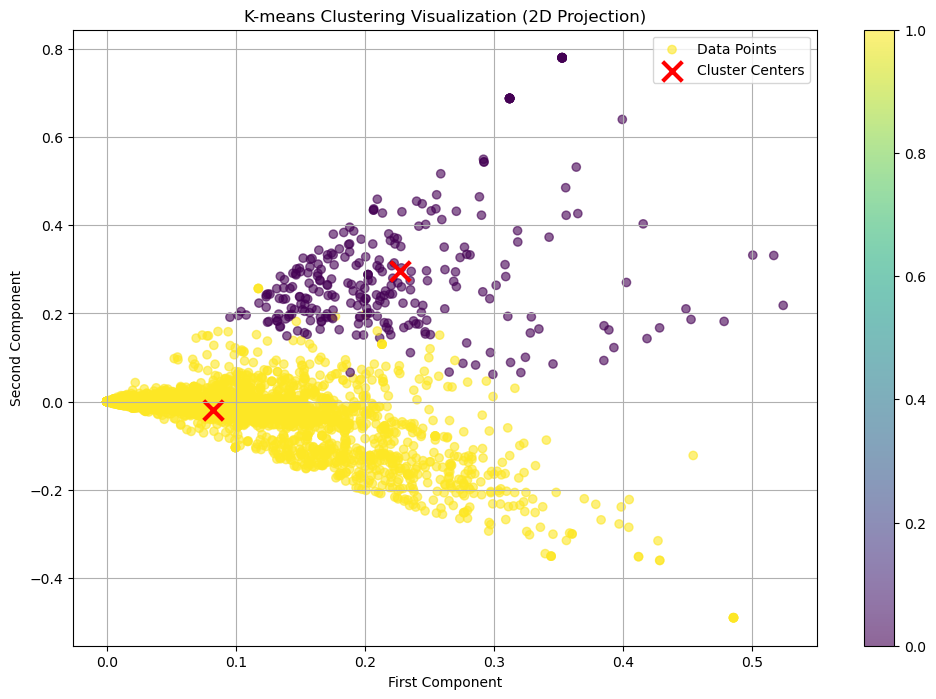


Clustering Information:
Cluster 0: 278 samples (5.6%)
Cluster 1: 4722 samples (94.4%)

Silhouette Score: 0.726
Inertia: 1163.78


In [20]:
def perform_clustering_analysis(X, n_clusters=2, sample_size=5000):
    """
    Perform clustering analysis on the data with proper handling of sparse matrices
    """
    # Sample the data if it's too large
    if X.shape[0] > sample_size:
        np.random.seed(42)
        indices = np.random.choice(X.shape[0], sample_size, replace=False)
        X_sample = X[indices]
    else:
        X_sample = X
        sample_size = X.shape[0]

    # First SVD reduction to 50 dimensions
    print("Reducing dimensions to 50...")
    svd_50 = TruncatedSVD(n_components=50, random_state=42)
    X_reduced_50 = svd_50.fit_transform(X_sample)

    # Perform K-means clustering on the 50-dimensional data
    print("Performing K-means clustering...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_reduced_50)

    # Second SVD reduction to 2D for visualization
    print("Reducing dimensions to 2D for visualization...")
    svd_2d = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd_2d.fit_transform(X_reduced_50)  # Reduce from 50D to 2D

    # Transform cluster centers from 50D to 2D
    centers_2d = svd_2d.transform(kmeans.cluster_centers_)

    # Visualization
    plt.figure(figsize=(12, 8))

    # Plot data points
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1],
                         c=clusters,
                         cmap='viridis',
                         alpha=0.6,
                         label='Data Points')

    # Plot cluster centers
    plt.scatter(centers_2d[:, 0], centers_2d[:, 1],
               c='red',
               marker='x',
               s=200,
               linewidths=3,
               label='Cluster Centers')

    plt.colorbar(scatter)
    plt.xlabel('First Component')
    plt.ylabel('Second Component')
    plt.title('K-means Clustering Visualization (2D Projection)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print clustering information
    print("\nClustering Information:")
    for i in range(n_clusters):
        cluster_size = np.sum(clusters == i)
        print(f"Cluster {i}: {cluster_size} samples ({cluster_size/sample_size:.1%})")

    return kmeans, clusters, X_2d

# Function to plot elbow curve
def plot_elbow_curve(X, max_clusters=10):
    inertias = []
    K = range(1, max_clusters + 1)

    for k in K:
        print(f"Testing k={k}...")
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(K, inertias, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.grid(True)
    plt.show()

# Main execution
try:
    # Perform clustering analysis
    kmeans_model, cluster_labels, X_visualization = perform_clustering_analysis(
        X,                  # Your TF-IDF matrix
        n_clusters=2,       # Number of clusters
        sample_size=5000    # Sample size for analysis
    )

    if kmeans_model is not None:
        # Calculate silhouette score
        silhouette_avg = silhouette_score(X_visualization, cluster_labels)
        print(f"\nSilhouette Score: {silhouette_avg:.3f}")
        print(f"Inertia: {kmeans_model.inertia_:.2f}")

        # Uncomment to run elbow curve analysis
        # plot_elbow_curve(X_visualization)

except Exception as e:
    print(f"An error occurred: {str(e)}")

In [21]:
def plot_roc_curve(model, X_test, y_test, model_name="Model"):
    """
    Plot ROC curve for a given model
    """
    # Get prediction probabilities
    y_pred_proba = model.predict_proba(X_test)[:,1]

    # Calculate ROC curve points
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return roc_auc

def plot_multiple_roc_curves(models, names, X_test, y_test):
    """
    Plot ROC curves for multiple models on the same graph
    """
    plt.figure(figsize=(10, 8))

    for model, name in zip(models, names):
        # Get prediction probabilities
        y_pred_proba = model.predict_proba(X_test)[:,1]

        # Calculate ROC curve points
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.75    159494
           1       0.76      0.74      0.75    160506

    accuracy                           0.75    320000
   macro avg       0.75      0.75      0.75    320000
weighted avg       0.75      0.75      0.75    320000



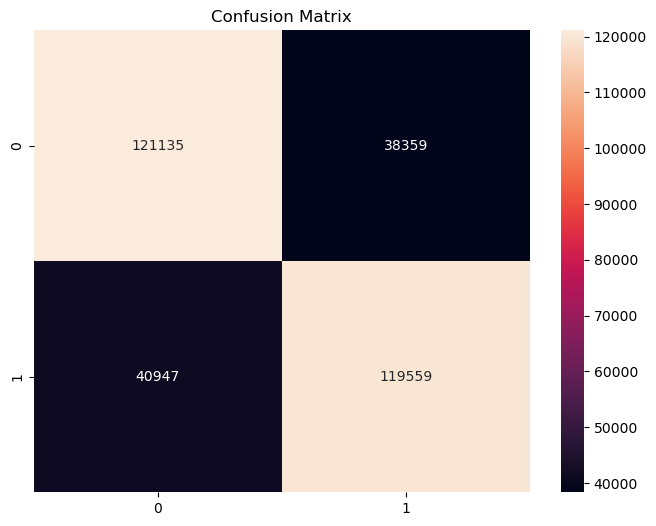


Cross-validation scores: [0.75107422 0.75074219 0.75253906 0.75176172 0.75164844]
Average CV score: 0.751553125


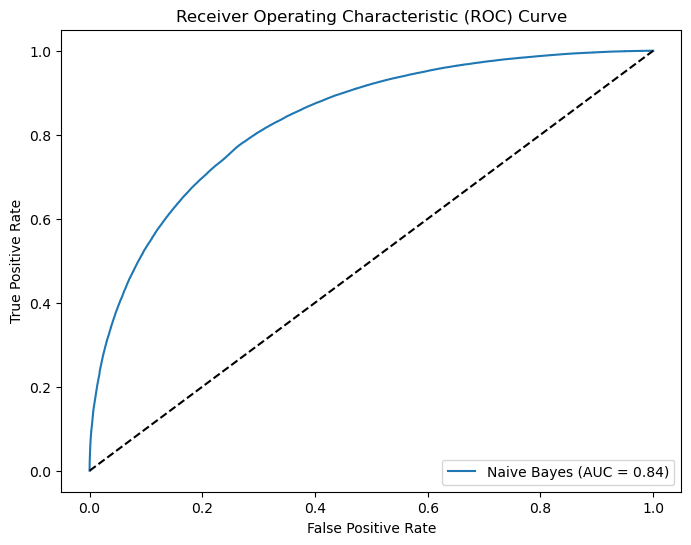


ROC AUC Score: 0.836


In [22]:
def plot_roc_curve(model, X_test, y_test, model_name):
    # Get prediction probabilities
    y_pred_proba = model.predict_proba(X_test)[:,1]

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    return roc_auc

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Print evaluation metrics
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.show()

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print("\nCross-validation scores:", cv_scores)
    print("Average CV score:", cv_scores.mean())

    roc_auc = plot_roc_curve(model, X_test, y_test, model_name)
    print(f"\nROC AUC Score: {roc_auc:.3f}")

# Baseline model
baseline_model = MultinomialNB()
evaluate_model(baseline_model, X_train, X_test, y_train, y_test, "Naive Bayes")

In [23]:
def analyze_logistic_regression_hyperparameters(X_train, y_train, X_test, y_test):
    """
    Detailed analysis of Logistic Regression hyperparameters
    """
    print("\n## Logistic Regression Hyperparameter Analysis ##")

    # Test different regularization strengths
    c_values = [100, 10, 1.0, 0.1, 0.01, 0.001]
    penalties = ['l1', 'l2', 'elasticnet', 'none']
    solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

    # Create parameter grid
    param_grid = {
        'C': c_values,
        'penalty': penalties,
        'solver': solvers,
        'max_iter': [1000]
    }

    # Initialize model and GridSearchCV
    lr = LogisticRegression()
    grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Plot results
    plt.figure(figsize=(12, 6))
    results_df = pd.DataFrame(grid_search.cv_results_)

    # Plot C parameter impact
    plt.subplot(1, 2, 1)
    for penalty in penalties:
        mask = results_df['param_penalty'] == penalty
        plt.plot(c_values, results_df[mask]['mean_test_score'],
                label=f'penalty={penalty}')

    plt.xscale('log')
    plt.xlabel('C Parameter (Regularization Strength)')
    plt.ylabel('Cross-validation Score')
    plt.title('Impact of C Parameter and Penalty')
    plt.legend()
    plt.grid(True)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76    159494
           1       0.75      0.79      0.77    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



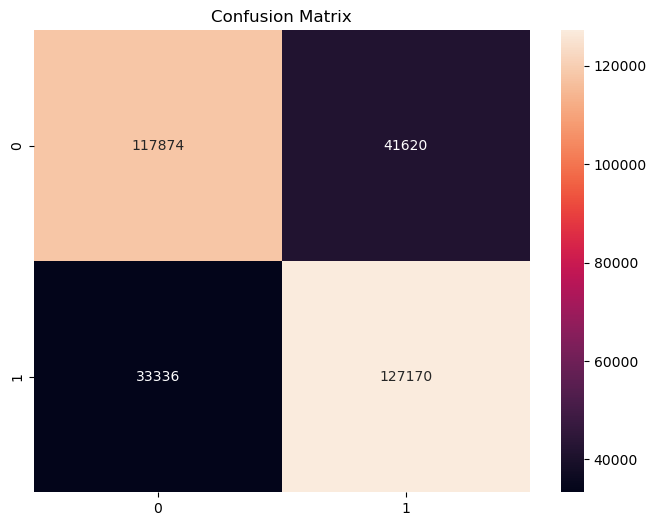


Cross-validation scores: [0.76517187 0.76521875 0.76596094 0.76471484 0.76529687]
Average CV score: 0.76527265625


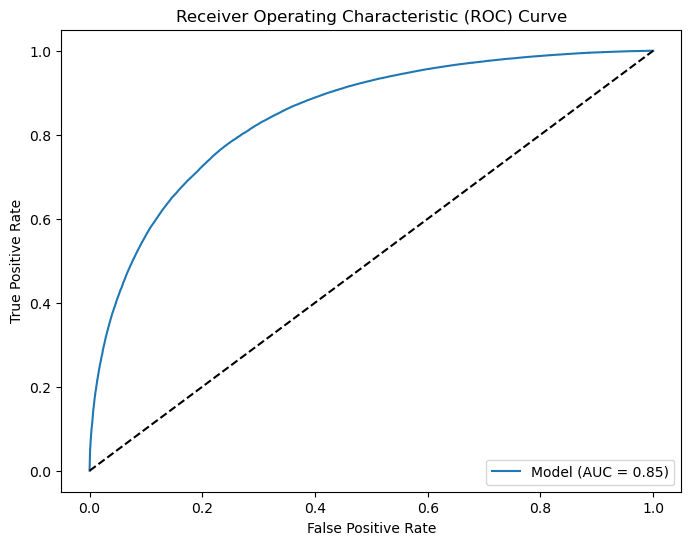


ROC AUC Score: 0.847


In [24]:
# Improved Model 1: Logistic Regression with Regularization
lr_model = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
evaluate_model(lr_model, X_train, X_test, y_train, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.73      0.76    159494
           1       0.75      0.80      0.77    160506

    accuracy                           0.76    320000
   macro avg       0.77      0.76      0.76    320000
weighted avg       0.77      0.76      0.76    320000



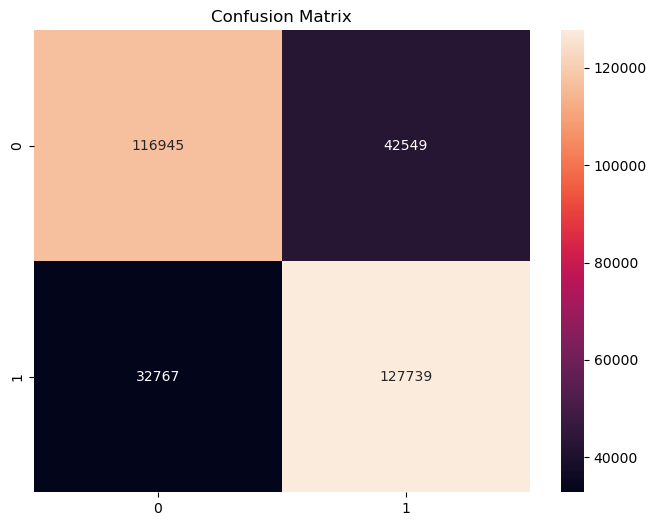


Cross-validation scores: [0.76503125 0.76436328 0.76467578 0.76407422 0.765     ]
Average CV score: 0.76462890625


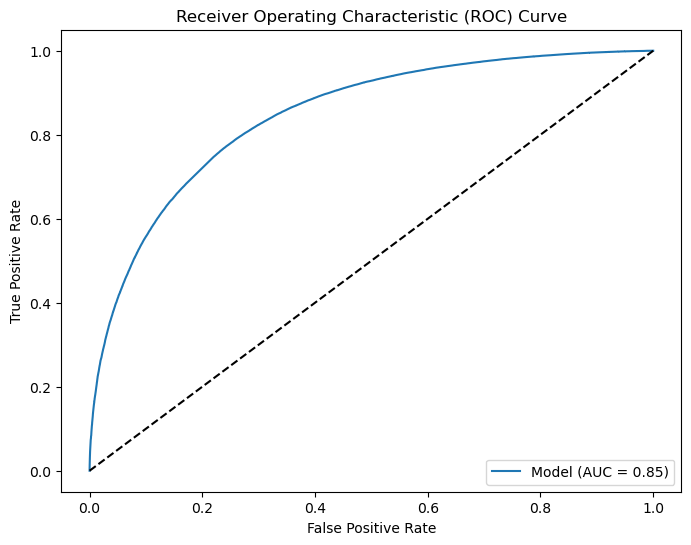


ROC AUC Score: 0.846


In [25]:
# Improved Model 2: Feature Selection with Chi-squared test
# Select top 3000 features
selector = SelectKBest(chi2, k=3000)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Train model with selected features
lr_model_selected = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
evaluate_model(lr_model_selected, X_train_selected, X_test_selected, y_train, y_test)

In [26]:
def plot_multiple_roc_curves(models, names, X_test, y_test):
    plt.figure(figsize=(10, 8))

    for model, name in zip(models, names):
        # Get prediction probabilities
        y_pred_proba = model.predict_proba(X_test)[:,1]

        # Calculate ROC curve points
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


Initial shapes:
Training data shape: (1280000, 5000)
Test data shape: (320000, 5000)


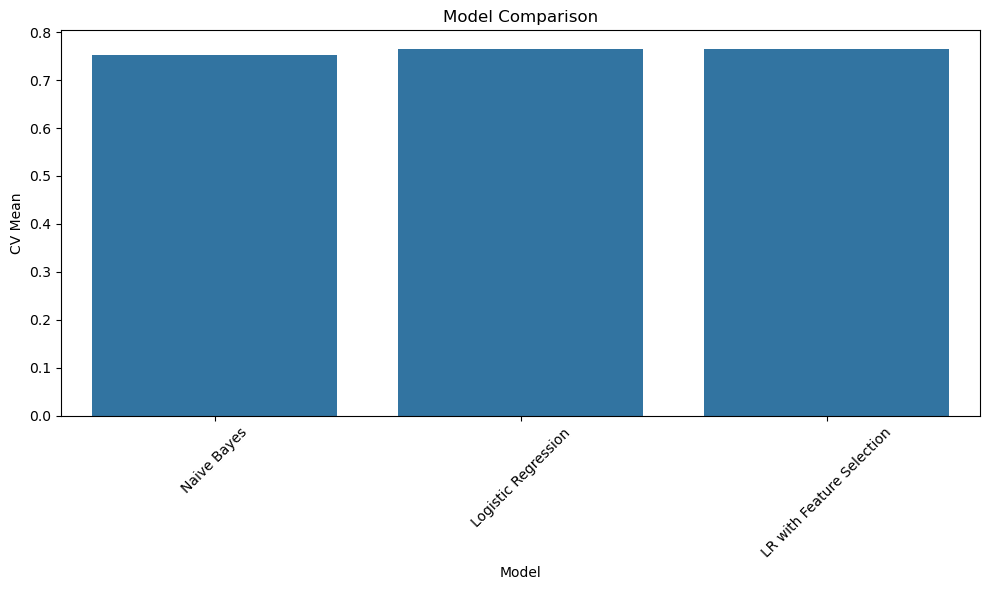

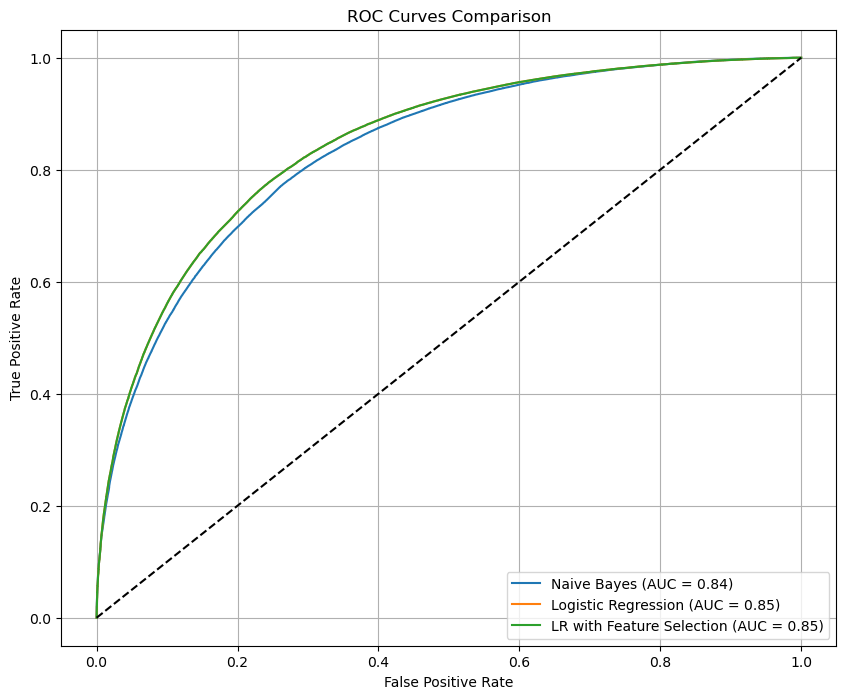

,Model,CV Mean,CV Std
0,Naive Bayes,0.751553,0.000618
1,Logistic Regression,0.765273,0.000400
2,LR with Feature Selection,0.765273,0.000400


In [27]:
def compare_models(models, names, X_train, X_test, y_train, y_test):
    results = []
    fitted_models = []

    # First, fit all models
    for model, name in zip(models, names):
        # Create a new instance of the model
        new_model = clone(model)
        # Fit the model
        new_model.fit(X_train, y_train)
        fitted_models.append(new_model)

        # Calculate cross-validation scores
        cv_scores = cross_val_score(new_model, X_train, y_train, cv=5)

        # Store results
        results.append({
            'Model': name,
            'CV Mean': cv_scores.mean(),
            'CV Std': cv_scores.std()
        })

    # Create DataFrame with results
    results_df = pd.DataFrame(results)

    # Plot comparison bar chart
    plt.figure(figsize=(10, 6))
    sns.barplot(data=results_df, x='Model', y='CV Mean')
    plt.title('Model Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot ROC curves
    plot_multiple_roc_curves(fitted_models, names, X_test, y_test)

    return results_df

models = [baseline_model, lr_model, lr_model_selected]
names = ['Naive Bayes', 'Logistic Regression', 'LR with Feature Selection']
# Print initial shapes
print("Initial shapes:")
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# If using feature selection, apply it first
if hasattr(lr_model_selected, 'get_support'):
    # Get selected features mask
    selector = SelectKBest(f_classif, k=3000)  # Adjust k as needed
    selector.fit(X_train, y_train)

    # Transform both training and test data
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    print("\nShapes after feature selection:")
    print(f"Training data shape: {X_train_selected.shape}")
    print(f"Test data shape: {X_test_selected.shape}")

    # Create and fit new models with selected features
    baseline_model_selected = MultinomialNB().fit(X_train_selected, y_train)
    lr_model_selected = LogisticRegression(random_state=42).fit(X_train_selected, y_train)

    # Update models list
    models = [baseline_model_selected, lr_model_selected]
    names = ['Naive Bayes', 'Logistic Regression']

    # Compare models using selected features
    comparison_results = compare_models(models, names, X_train_selected, X_test_selected, y_train, y_test)
else:
    # If no feature selection, use original data
    comparison_results = compare_models(models, names, X_train, X_test, y_train, y_test)

display(comparison_results)

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.75    159494
           1       0.76      0.74      0.75    160506

    accuracy                           0.75    320000
   macro avg       0.75      0.75      0.75    320000
weighted avg       0.75      0.75      0.75    320000



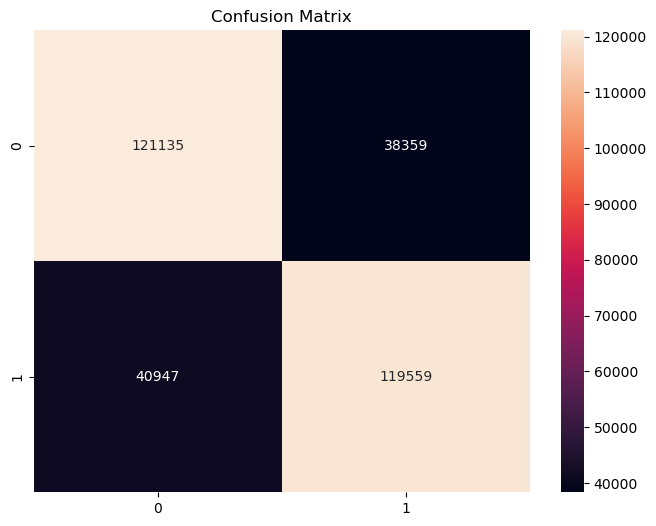


Cross-validation scores: [0.75107422 0.75074219 0.75253906 0.75176172 0.75164844]
Average CV score: 0.751553125


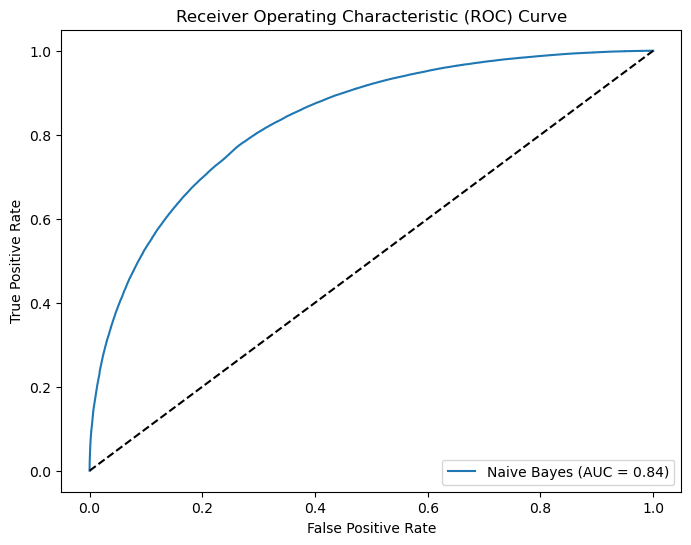


ROC AUC Score: 0.836
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76    159494
           1       0.75      0.79      0.77    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



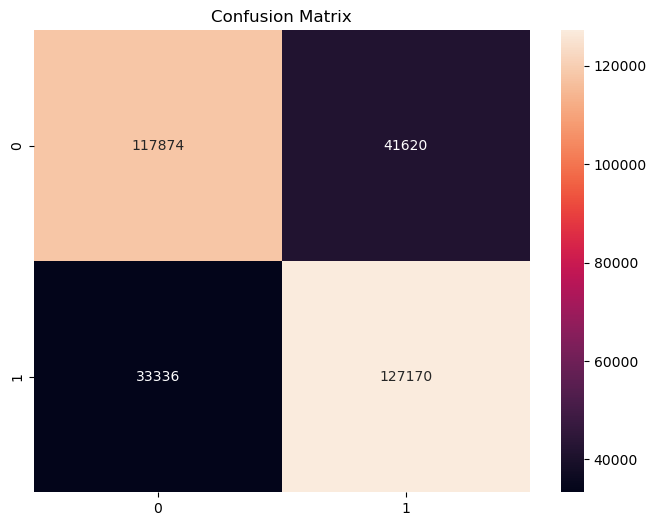


Cross-validation scores: [0.76517187 0.76521875 0.76596094 0.76471484 0.76529687]
Average CV score: 0.76527265625


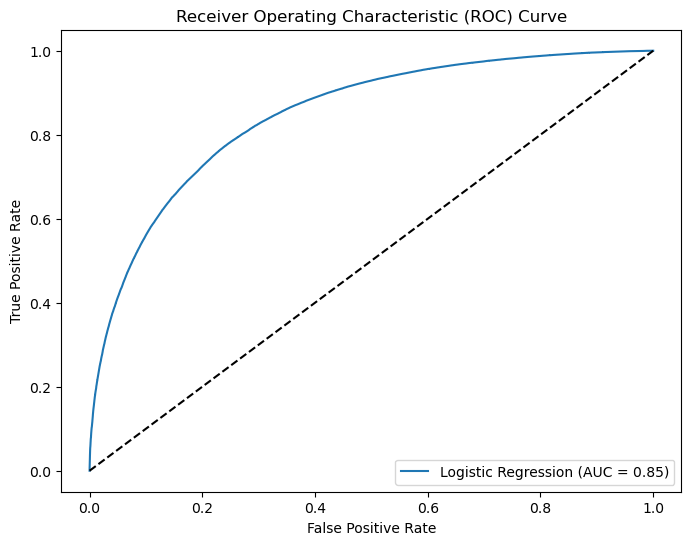


ROC AUC Score: 0.847
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.73      0.76    159494
           1       0.75      0.80      0.77    160506

    accuracy                           0.76    320000
   macro avg       0.77      0.76      0.76    320000
weighted avg       0.77      0.76      0.76    320000



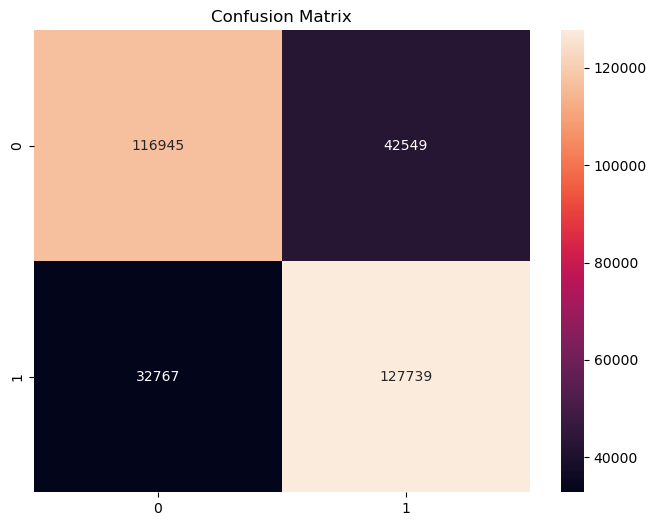


Cross-validation scores: [0.76503125 0.76436328 0.76467578 0.76407422 0.765     ]
Average CV score: 0.76462890625


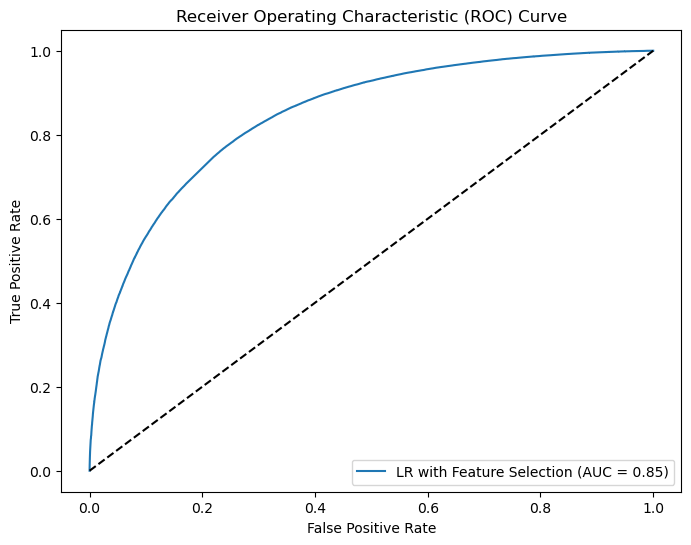


ROC AUC Score: 0.846


In [28]:
# For individual model evaluation
evaluate_model(baseline_model, X_train, X_test, y_train, y_test, "Naive Bayes")
evaluate_model(lr_model, X_train, X_test, y_train, y_test, "Logistic Regression")
evaluate_model(lr_model_selected, X_train_selected, X_test_selected, y_train, y_test,
              "LR with Feature Selection")

# # For model comparison
# models = [baseline_model, lr_model, lr_model_selected]
# names = ['Naive Bayes', 'Logistic Regression', 'LR with Feature Selection']
# comparison_results = compare_models(models, names, X_train, X_test, y_train, y_test)